# Анализ стоимости недвижимости
## Прикладное машинное обучение - глава 2

Импорт модулей

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

import pandas as pd
from pandas.plotting import scatter_matrix

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
# выделения тестового набора
# from sklearn.model_selection import train_test_split

# стратифицированная выборка
from sklearn.model_selection import StratifiedShuffleSplit
# работа с отсутствующими данными
from sklearn.impute import SimpleImputer
# унитарное кодирование
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# для трансформаторов
from sklearn.base import BaseEstimator, TransformerMixin
# конвейер и масштабирование
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


In [2]:
def fetch_housing_data (housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()


Запускаем только один раз, для скачивания

In [3]:
# fetch_housing_data()

## Первый обзор данных
Импорт данных в dataset

In [3]:
def load_housing_data (housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


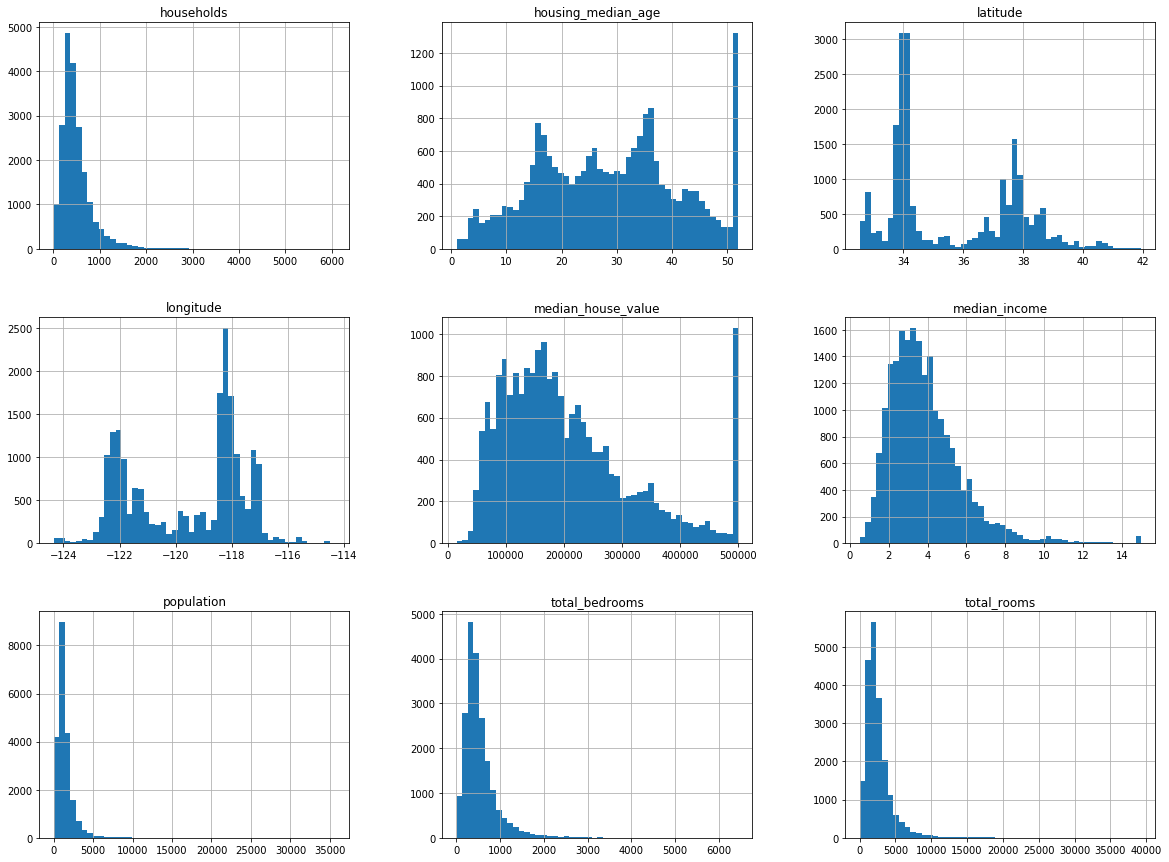

In [7]:
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

## Испытательный и тестовый наборы
Создадим испытательный набор данных. Разделим данные по медианному доходу на категории (стратифицированная выборка). Атрибут категории дохода получается делением медианного дохода на 1,5, округление для получения дескретных категорий и объединение всех категорий больше 5 в одну.

In [8]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True)

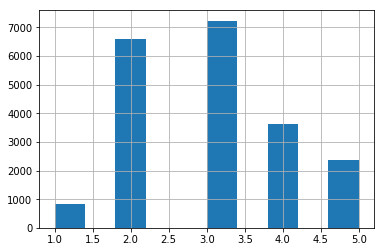

In [9]:
housing["income_cat"].hist()
plt.show()

In [10]:
split =StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


Распределение стратов в исходных данных, тестовом и тренировочных наборах.

In [11]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [12]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [13]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Убираем атрибут income_cat, больше он не нужен

In [14]:
for set_ in (strat_test_set, strat_train_set):
    set_.drop("income_cat", axis = 1, inplace = True)


## Визуализация данных

In [15]:
housing = strat_train_set.copy()

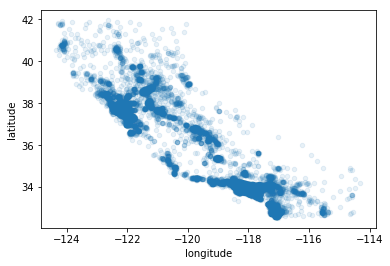

In [16]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)
plt.show()

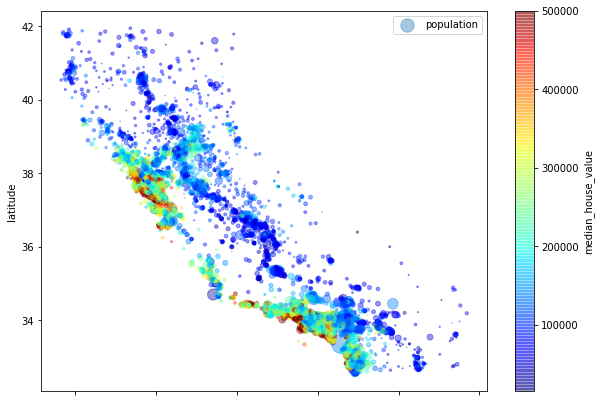

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100,
             label="population", figsize=(10, 7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

## Поиск связей
Посчитаем коэффициенты корреляции

In [18]:
corr_matrix = housing.corr()

In [19]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

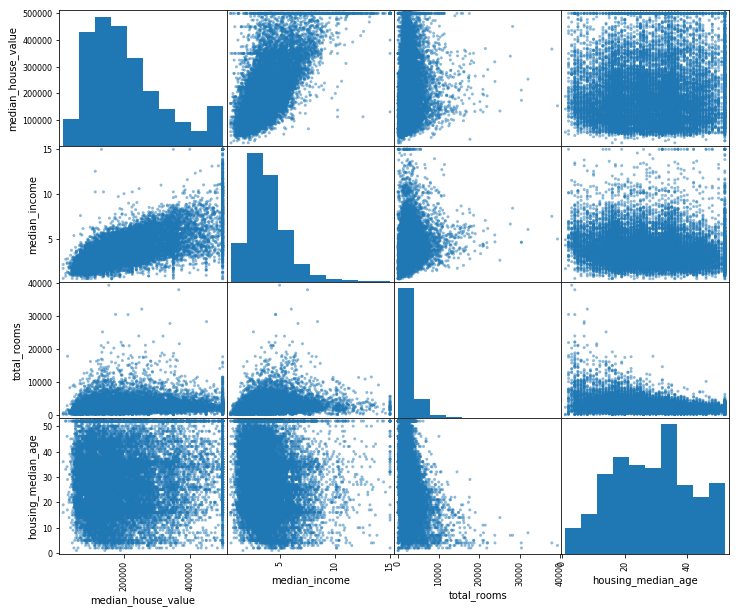

In [20]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 10))
plt.show()

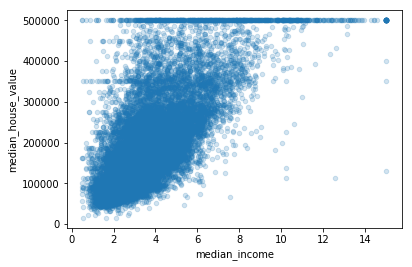

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2)
plt.show()

Введем некторые новые признаки: количество комнат в доме, количество спален относительно общего числа комнат и количесвто людей в доме.

In [22]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [95]:
best = abs(corr_matrix['median_house_value'].values) > 0.1

corr_matrix['median_house_value'].loc[best].index

Index(['latitude', 'housing_median_age', 'total_rooms', 'median_income',
       'median_house_value', 'rooms_per_household', 'bedrooms_per_room'],
      dtype='object')

In [24]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

Обработаем недостающие данные. 
Варианты:
* dropna() - удалить соответствующие строки
* drop() - удалить атрибут целиком
* fillna() - заполнить недостающие данными другими - median(), 0 и тд.
* класс Imputer модуля sklearn.preprocessing

In [25]:
imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [26]:
X = imputer.transform(housing_num)

In [27]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

выделим категориальный признак

In [28]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

Для перевода категорий в числовые признаки можно использовать метод pandas factorize(). Сопоставляет категорию с целым числом.

In [29]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [30]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

Для того чтобы разделить признаки по степени похожести, введем унитарное кодирование, активный атрибут будет равен 1, остальные в это время 0. reshape(-1, 1) - позволяет изменить одномерный массив в 2х мерный.

C версии 0.20 OneHotEncoder позволяет сразу обрабатывать текстовые признаки, без предварительного кодирования.

In [31]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

C:\Anaconda3\envs\mlbook\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [32]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

## Трансформаторы

Собственные трансформаторы для создания описанных выше комбинированных атрибутов.

In [33]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder (BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit (self, X, y = None):
        return self
    def transform (self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Масштабирование признаков

Два распространненых метода обеспечения одинакового масштаба:
* минимакс (min-max scaling) - нормализация
* стандартизация

При нормализации значения масштабируются так, чтобы попадать в диапазон от 0 до 1. MinMaxScaler в библиотеке sklearn.
Стандартизация позволяет получить распределение данных вокруг среднего значения с единичной дисперсией. sklearn имеет трансформатор StandardScaler

Масштабирование признаков нужно применять к обучающим данным, а не к полному набору.

## Конвейеры трансформации

Класс Pipeline библиотеки sklearn позволяет проводить трансформации в нужном порядке автоматически.

In [34]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Последовательно вызываются методы fit_transform() каждого трансформатора, последний вызывается протсо метод fit(). Метод transform() конвеера последовательно применяет все трансформации.

Добавим возможность передавать в конвеер сразу объект pandas.dataframe

In [35]:
class DataFrameSelector (BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values


Составляем конвейеры для последовательной обработки исходного dataframe. C версии 0.20 OneHotEncoder позволяет сразу обрабатывать текстовые признаки, без предварительного кодирования.

In [36]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy = "median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [37]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

<16512x16 sparse matrix of type '<class 'numpy.float64'>'
	with 198144 stored elements in Compressed Sparse Row format>

In [38]:
housing_prepared.shape

(16512, 16)

## Выбор и обучение модели

### Линейная модель

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Проверим модель на данных из обучающей выборки

In [47]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Прогнозы:", lin_reg.predict(some_data_prepared))
print("Метки:", list(some_labels))

Прогнозы: [210644.60466567 317768.80735284 210956.43317368  59218.98852867
 189747.55854361]
Метки: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Добавим расчет ошибки RMSE (корень из среднего квадратичного отклонения)

In [48]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

### Модель решающих деревьев (DecisionTreeRegressor)

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Оценка модели на обучающем наборе

In [50]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Модель крайне переобучена данными!!!

Пока модель не готова, нельзя брать испытательные данный. Проверять будем делением обучающих данных:
* train_test_split() - разделить данные еще раз на обучающие и тестовые
* Перекрестная проверка по К блокам. Данные разбиваются на 10 блоков, модель обучается и проверяется 10 раз, каждый раз обучение идет на 9 блоках и проверка на оставшемся.

In [51]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [52]:
def display_scores(scores):
    print("Суммы оценок:", scores)
    print("Среднее:", scores.mean())
    print("Стандартное отклонение:", scores.std())
    
display_scores(tree_rmse_scores)

Суммы оценок: [68742.99994327 67428.27353445 70668.32300252 69775.55769584
 71975.15882238 75881.53446955 70981.82017043 71552.62355198
 77653.07757884 69665.07721034]
Среднее: 71432.44459795897
Стандартное отклонение: 2978.623195567063


Проведем кросс-валидацию для линейной модели:

In [53]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Суммы оценок: [66782.73844382 66960.11808403 70347.95243591 74739.57053246
 68031.13389671 71193.84183557 64969.63056733 68281.61137987
 71552.9157081  67665.10081821]
Среднее: 69052.46137020056
Стандартное отклонение: 2731.6740048855654


### Модель случайных лесов (RandomForestRegressor)

In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

C:\Anaconda3\envs\mlbook\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [55]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22065.89798776716

In [56]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Суммы оценок: [52298.38189136 49416.55329642 52366.0136478  55366.22669889
 52270.74513339 55864.29017049 51027.52402305 50663.56644083
 55731.66597408 51988.08164945]
Среднее: 52699.30489257646
Стандартное отклонение: 2121.3599905763986


Сохраним модель

In [105]:
from sklearn.externals import joblib

joblib.dump(forest_reg, "forest.pkl")

['forest.pkl']

## Точная настройка моделей

### Решетчатый поиск

In [57]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

Wall time: 4min 52s


In [59]:
cvres = grid_search

In [60]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


64461.282247047515 {'max_features': 2, 'n_estimators': 3}
55608.33411559148 {'max_features': 2, 'n_estimators': 10}
52965.89838419428 {'max_features': 2, 'n_estimators': 30}
59569.13939883284 {'max_features': 4, 'n_estimators': 3}
53120.6342142006 {'max_features': 4, 'n_estimators': 10}
50473.06984851915 {'max_features': 4, 'n_estimators': 30}
59110.502053803575 {'max_features': 6, 'n_estimators': 3}
52396.64807946605 {'max_features': 6, 'n_estimators': 10}
50097.46008773636 {'max_features': 6, 'n_estimators': 30}
58863.185479990556 {'max_features': 8, 'n_estimators': 3}
52103.73767866802 {'max_features': 8, 'n_estimators': 10}
49952.42625874282 {'max_features': 8, 'n_estimators': 30}
62001.76752122336 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54388.954960079456 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60240.59645599852 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52513.54305647599 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [61]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

### Рандомизированный поиск

In [64]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [3, 10, 30],
    'max_features': [2, 4, 6, 8],
    'bootstrap': [True, False],
}


forest_reg = RandomForestRegressor()
rand_search = RandomizedSearchCV(forest_reg, param_distributions = param_grid, cv=5, scoring='neg_mean_squared_error')
rand_search.fit(housing_prepared, housing_labels)

rand_search.best_params_

Wall time: 4min 21s


In [65]:
rand_search.best_params_

{'n_estimators': 30, 'max_features': 6, 'bootstrap': False}

## Анализ моделей и ошибок

Для RandomForest можно обозначить относительную важность каждого атрибута

In [121]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([7.17705844e-02, 6.27126719e-02, 4.20953985e-02, 1.53111574e-02,
       1.49301307e-02, 1.46367251e-02, 1.54052434e-02, 3.71874409e-01,
       5.83233217e-02, 1.12803522e-01, 5.29239070e-02, 5.45134149e-03,
       1.55556247e-01, 5.25852398e-05, 2.39398822e-03, 3.75876665e-03])

In [123]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_rooms']
cat_encoder = cat_pipeline.named_steps['cat_encoder']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.37187440860221427, 'median_income'),
 (0.1555562472506891, 'INLAND'),
 (0.11280352234924755, 'pop_per_hhold'),
 (0.07177058443575242, 'longitude'),
 (0.0627126719457287, 'latitude'),
 (0.05832332167294318, 'rooms_per_hhold'),
 (0.05292390701249315, 'bedrooms_per_rooms'),
 (0.04209539845121854, 'housing_median_age'),
 (0.015405243417282357, 'households'),
 (0.015311157433878604, 'total_rooms'),
 (0.01493013071276555, 'total_bedrooms'),
 (0.014636725114404076, 'population'),
 (0.005451341494439797, '<1H OCEAN'),
 (0.003758766645652548, 'NEAR OCEAN'),
 (0.002393988221449791, 'NEAR BAY'),
 (5.258523984026092e-05, 'ISLAND')]

## Оценка системы с помощью испытательного набора

In [116]:
final_model = rand_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [117]:
final_rmse

54815.96683831028

Обратить внимание, что используется transform() в pipeline, а не fit_transform()!!!

### Метод опорных векторов

In [79]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=100, gamma='scale')

svr_rbf.fit(housing_prepared, housing_labels)

housing_predictions = svr_rbf.predict(housing_prepared)
rbf_mse = mean_squared_error(housing_labels, housing_predictions)
rbf_rmse = np.sqrt(rbf_mse)
rbf_rmse

94766.04590701089

In [80]:
svr_lin = SVR(kernel='linear', C=1)

svr_lin.fit(housing_prepared, housing_labels)

housing_predictions = svr_lin.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

111094.6308539982

In [114]:
from scipy.stats import randint as sp_randint

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': sp_randint(1, 200000),
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'gamma': ['scale'],
}

svr_reg = SVR()
rand_search = RandomizedSearchCV(svr_reg, param_distributions = param_grid, cv=5,
                                 scoring='neg_mean_squared_error', n_iter=10,
                                verbose = 2, n_jobs = 4, random_state = 42)
rand_search.fit(housing_prepared, housing_labels)

rand_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.1min
C:\Anaconda3\envs\mlbook\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  8.0min finished


{'C': 184780, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [115]:
rand_search.best_estimator_

SVR(C=184780, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)